# Unsupervised Deep Learning Project

**Authors:** Ameya Kulkarni, Felipe Mansilla, Jules Crevola, Giacomo Lustri

---

This notebook is designed to tackle two core unsupervised deep learning challenges as outlined in the project guidelines:

## 1. Anomaly Detection on Corrupted EMNIST
- Explore techniques for unsupervised anomaly detection on a modified EMNIST dataset.
- Identify dataset corruptions and propose methods for reconstruction.
- Propose appropriate metrics to quantify improvements.

## 2. Exploration of Mode Collapse in GANs
- Train GANs on MNIST (without using labels) to investigate mode collapse.
- Experiment with multiple architectures and seeds to deliberately induce mode collapse.
- Propose and implement strategies to mitigate mode collapse, extending results to other datasets


# Part 1
## Anomaly detection on corrupted EMNIST

In this section we explore two ways of identifying corrupted images. We have a modified version of the EMNIST dataset which contains images which have been corrupted in different ways.

#### Loading the corrupted dataset

In [2]:
%reset

Nothing done.


In [18]:
# Imports

import os
import gc
import gzip
import math
import zipfile
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms, datasets
from torch.cuda.amp import autocast, GradScaler


In [ ]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# Delete large variables

# Manually trigger garbage collection
gc.collect()

# If you're using GPU, clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

if torch.mps.is_available():
    torch.mps.reset()

print("RAM and GPU cache cleared!")

RAM and GPU cache cleared!


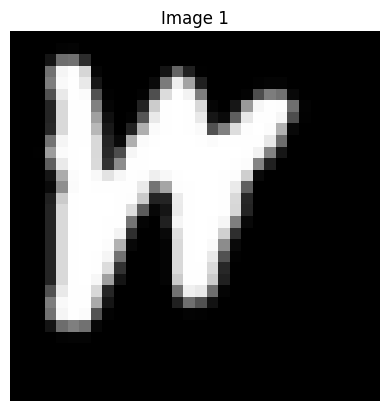

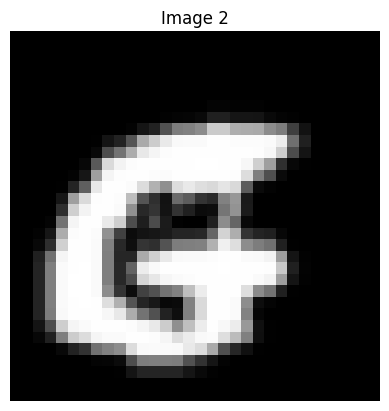

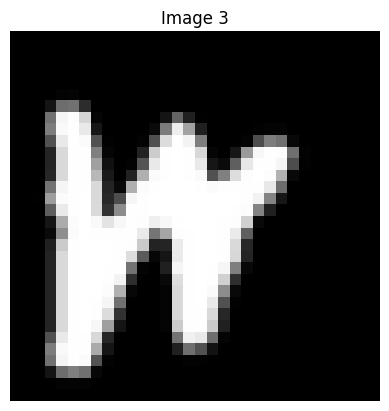

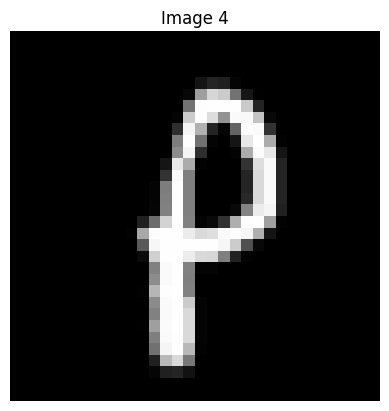

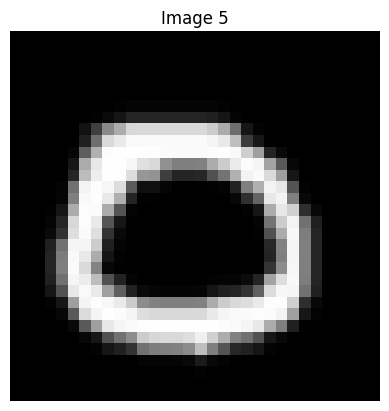

In [ ]:
# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, "r") as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)["all_imagesfinal"]  # Load the array
    return data


# Example usage
loaded_images = load_images_from_zip("corrupted_emnist.zip")

# Show the first 5 images
for i in range(5):
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()

## 1. Convolutional Auto-Encoders

#### Approach:
- A convolutional autoencoder is trained on a normal EMNIST dataset (without the labels)
- During inference, anomalies are detected based on reconstruction errors.
- Images which exceed certain thresholds (2 std deviations) from the mean error are flagged as anomalies 

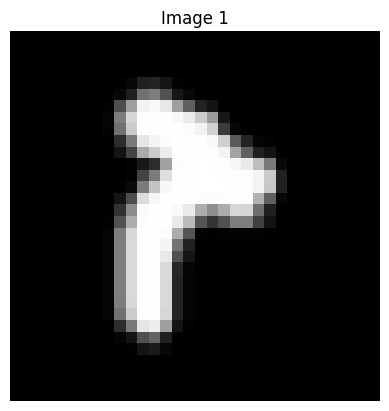

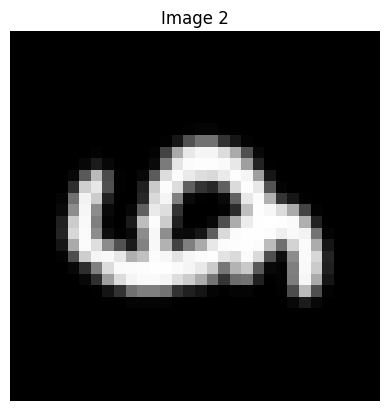

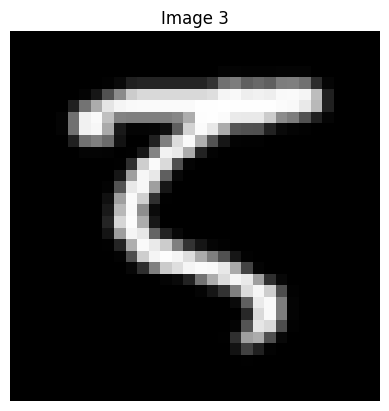

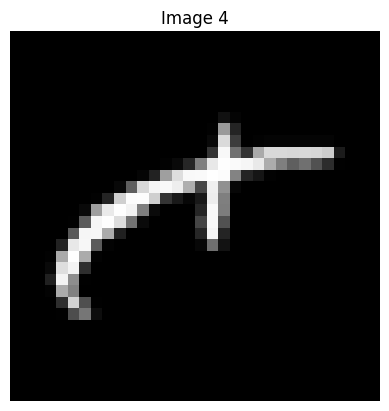

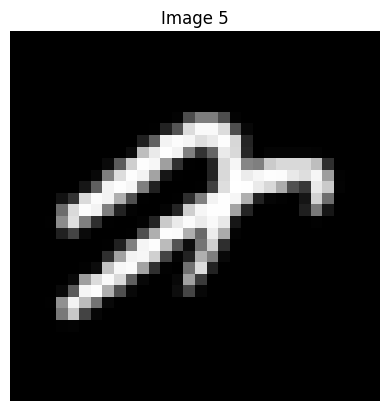

In [ ]:
# Generated code

# Function to extract images from the IDX3 file
def extract_images(file_path):
    with gzip.open(file_path, "rb") as f:
        # Skip the header (16 bytes)
        f.read(16)
        # Read the image data
        buffer = f.read()
        # Reshape into 28x28 arrays (native EMNIST format)
        data = np.frombuffer(buffer, dtype=np.uint8).reshape(-1, 28, 28)
    return data


# Path to the correct image file
file_path = "emnist-balanced-train-images-idx3-ubyte.gz"

# Extract EMNIST images
original_emnist_images = extract_images(file_path)


# Resize to 32x32 (Padding)
def resize_to_32x32(images):
    return np.pad(images, ((0, 0), (2, 2), (2, 2)), mode="constant")


# Pad EMNIST images to match 32x32
emnist_images_resized = resize_to_32x32(original_emnist_images)

# Show the first 5 padded images
for i in range(5):
    plt.imshow(emnist_images_resized[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()


In [20]:
# Enable GPU
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device}")

Using cuda


In [5]:
# Normalize & Convert to tensors
emnist_images_resized = emnist_images_resized / 255.0
emnist_images_tensor = torch.tensor(emnist_images_resized, dtype=torch.float32)
emnist_images_tensor = emnist_images_tensor.unsqueeze(1)


# Create a DataLoader
batch_size = 128
dataset = TensorDataset(emnist_images_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [6]:
# # Adapted Convolutional Autoencoder from the lab  AE_NoisyAE
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, output_padding=1, padding=1
            ),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [7]:
# Training loop
def train_model(model, loss_fn, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (data,) in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


In [8]:
# Initialize and train the model
model = ConvAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

train_model(model, loss_fn, train_loader, optimizer, epochs=3)


Epoch 1, Loss: 0.112841864410036
Epoch 2, Loss: 0.04321769786372468
Epoch 3, Loss: 0.002373952540788639


In [9]:
# Normalize and convert the corrupted images to tensors
corrupted_images = loaded_images / 255.0
corrupted_images_tensor = torch.tensor(corrupted_images, dtype=torch.float32)
corrupted_images_tensor = corrupted_images_tensor.unsqueeze(1)

In [10]:
# Evaluate reconstruction error on corrupted data
model.eval()
with torch.no_grad():
    corrupted_data = corrupted_images_tensor.to(device)
    reconstructed = model(corrupted_data)
    reconstruction_errors = torch.mean(
        (reconstructed - corrupted_data) ** 2, dim=(1, 2, 3)
    )
    print(f"Mean Reconstruction Error: {reconstruction_errors.mean().item()}")


Mean Reconstruction Error: 0.0032247311901301146


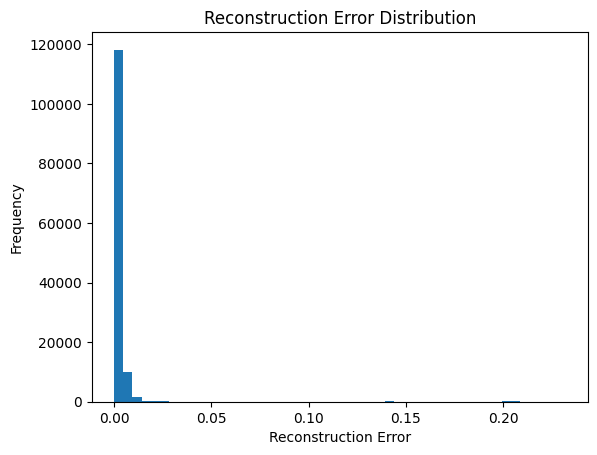

In [11]:
# Plot reconstruction errors distribution

plt.hist(reconstruction_errors.cpu().numpy(), bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()


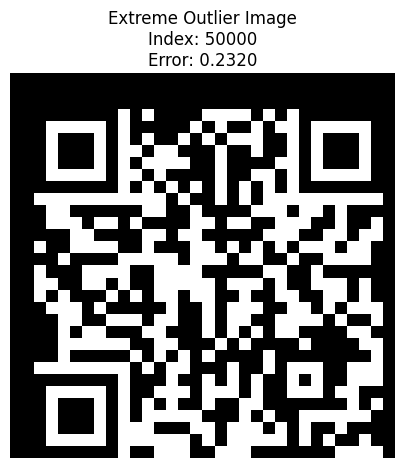

In [13]:
# Find the index of the maximum reconstruction error
outlier_index = torch.argmax(reconstruction_errors).item()

# Plot the image with the extreme reconstruction error
plt.figure(figsize=(5, 5))
plt.imshow(corrupted_images_tensor[outlier_index, 0].cpu(), cmap="gray")
plt.title(
    f"Extreme Outlier Image\nIndex: {outlier_index}\nError: {reconstruction_errors[outlier_index]:.4f}"
)
plt.axis("off")
plt.show()


This QR code links to an OpenAI site with the DALL-E decoder pickle file hahahaha

https://cdn.openai.com/dall-e/decoder.pkl

In [14]:
# Evaluate reconstruction errors
def detect_anomalies(model, corrupted_data, threshold_factor):
    model.eval()
    with torch.no_grad():
        corrupted_data = corrupted_data.to(device)
        reconstructed = model(corrupted_data)
        # Calculate reconstruction errors
        errors = torch.mean((reconstructed - corrupted_data) ** 2, dim=(1, 2, 3))
        errors = errors.cpu().numpy()
        # Set anomaly threshold
        threshold = errors.mean() + threshold_factor * errors.std()
        anomalies = errors > threshold
        return anomalies, errors, threshold


# Detect anomalies in the corrupted dataset
anomalies, errors, threshold = detect_anomalies(
    model, corrupted_images_tensor, threshold_factor=2
)
print(f"Detected {anomalies.sum()} anomalies out of {len(errors)} images.")


Detected 694 anomalies out of 131057 images.


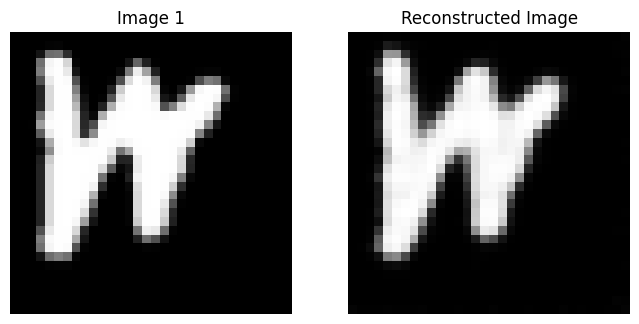

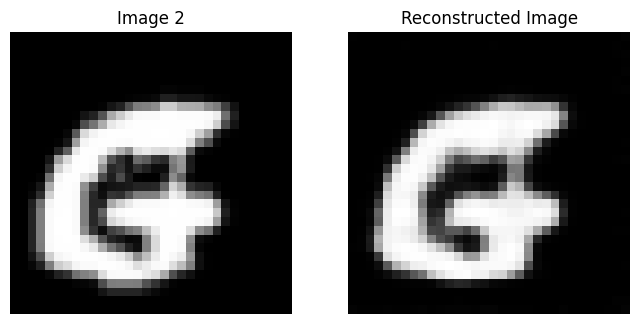

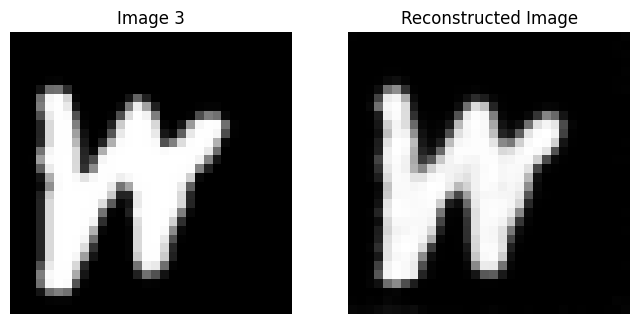

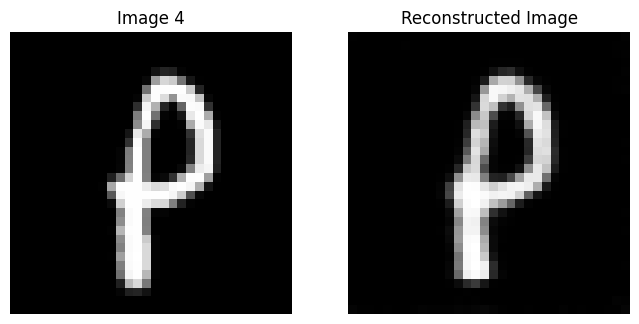

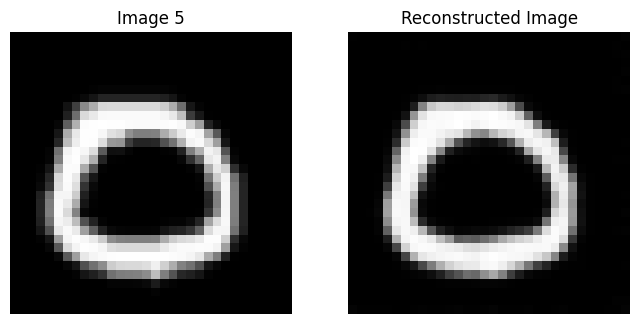

In [15]:
# Visualize the first 5 non-anomalous images
non_anomalous_indices = np.where(~anomalies)[0]
for i in non_anomalous_indices[:5]:
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    # Visualize reconstruction
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[i, 0].cpu().numpy(), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()


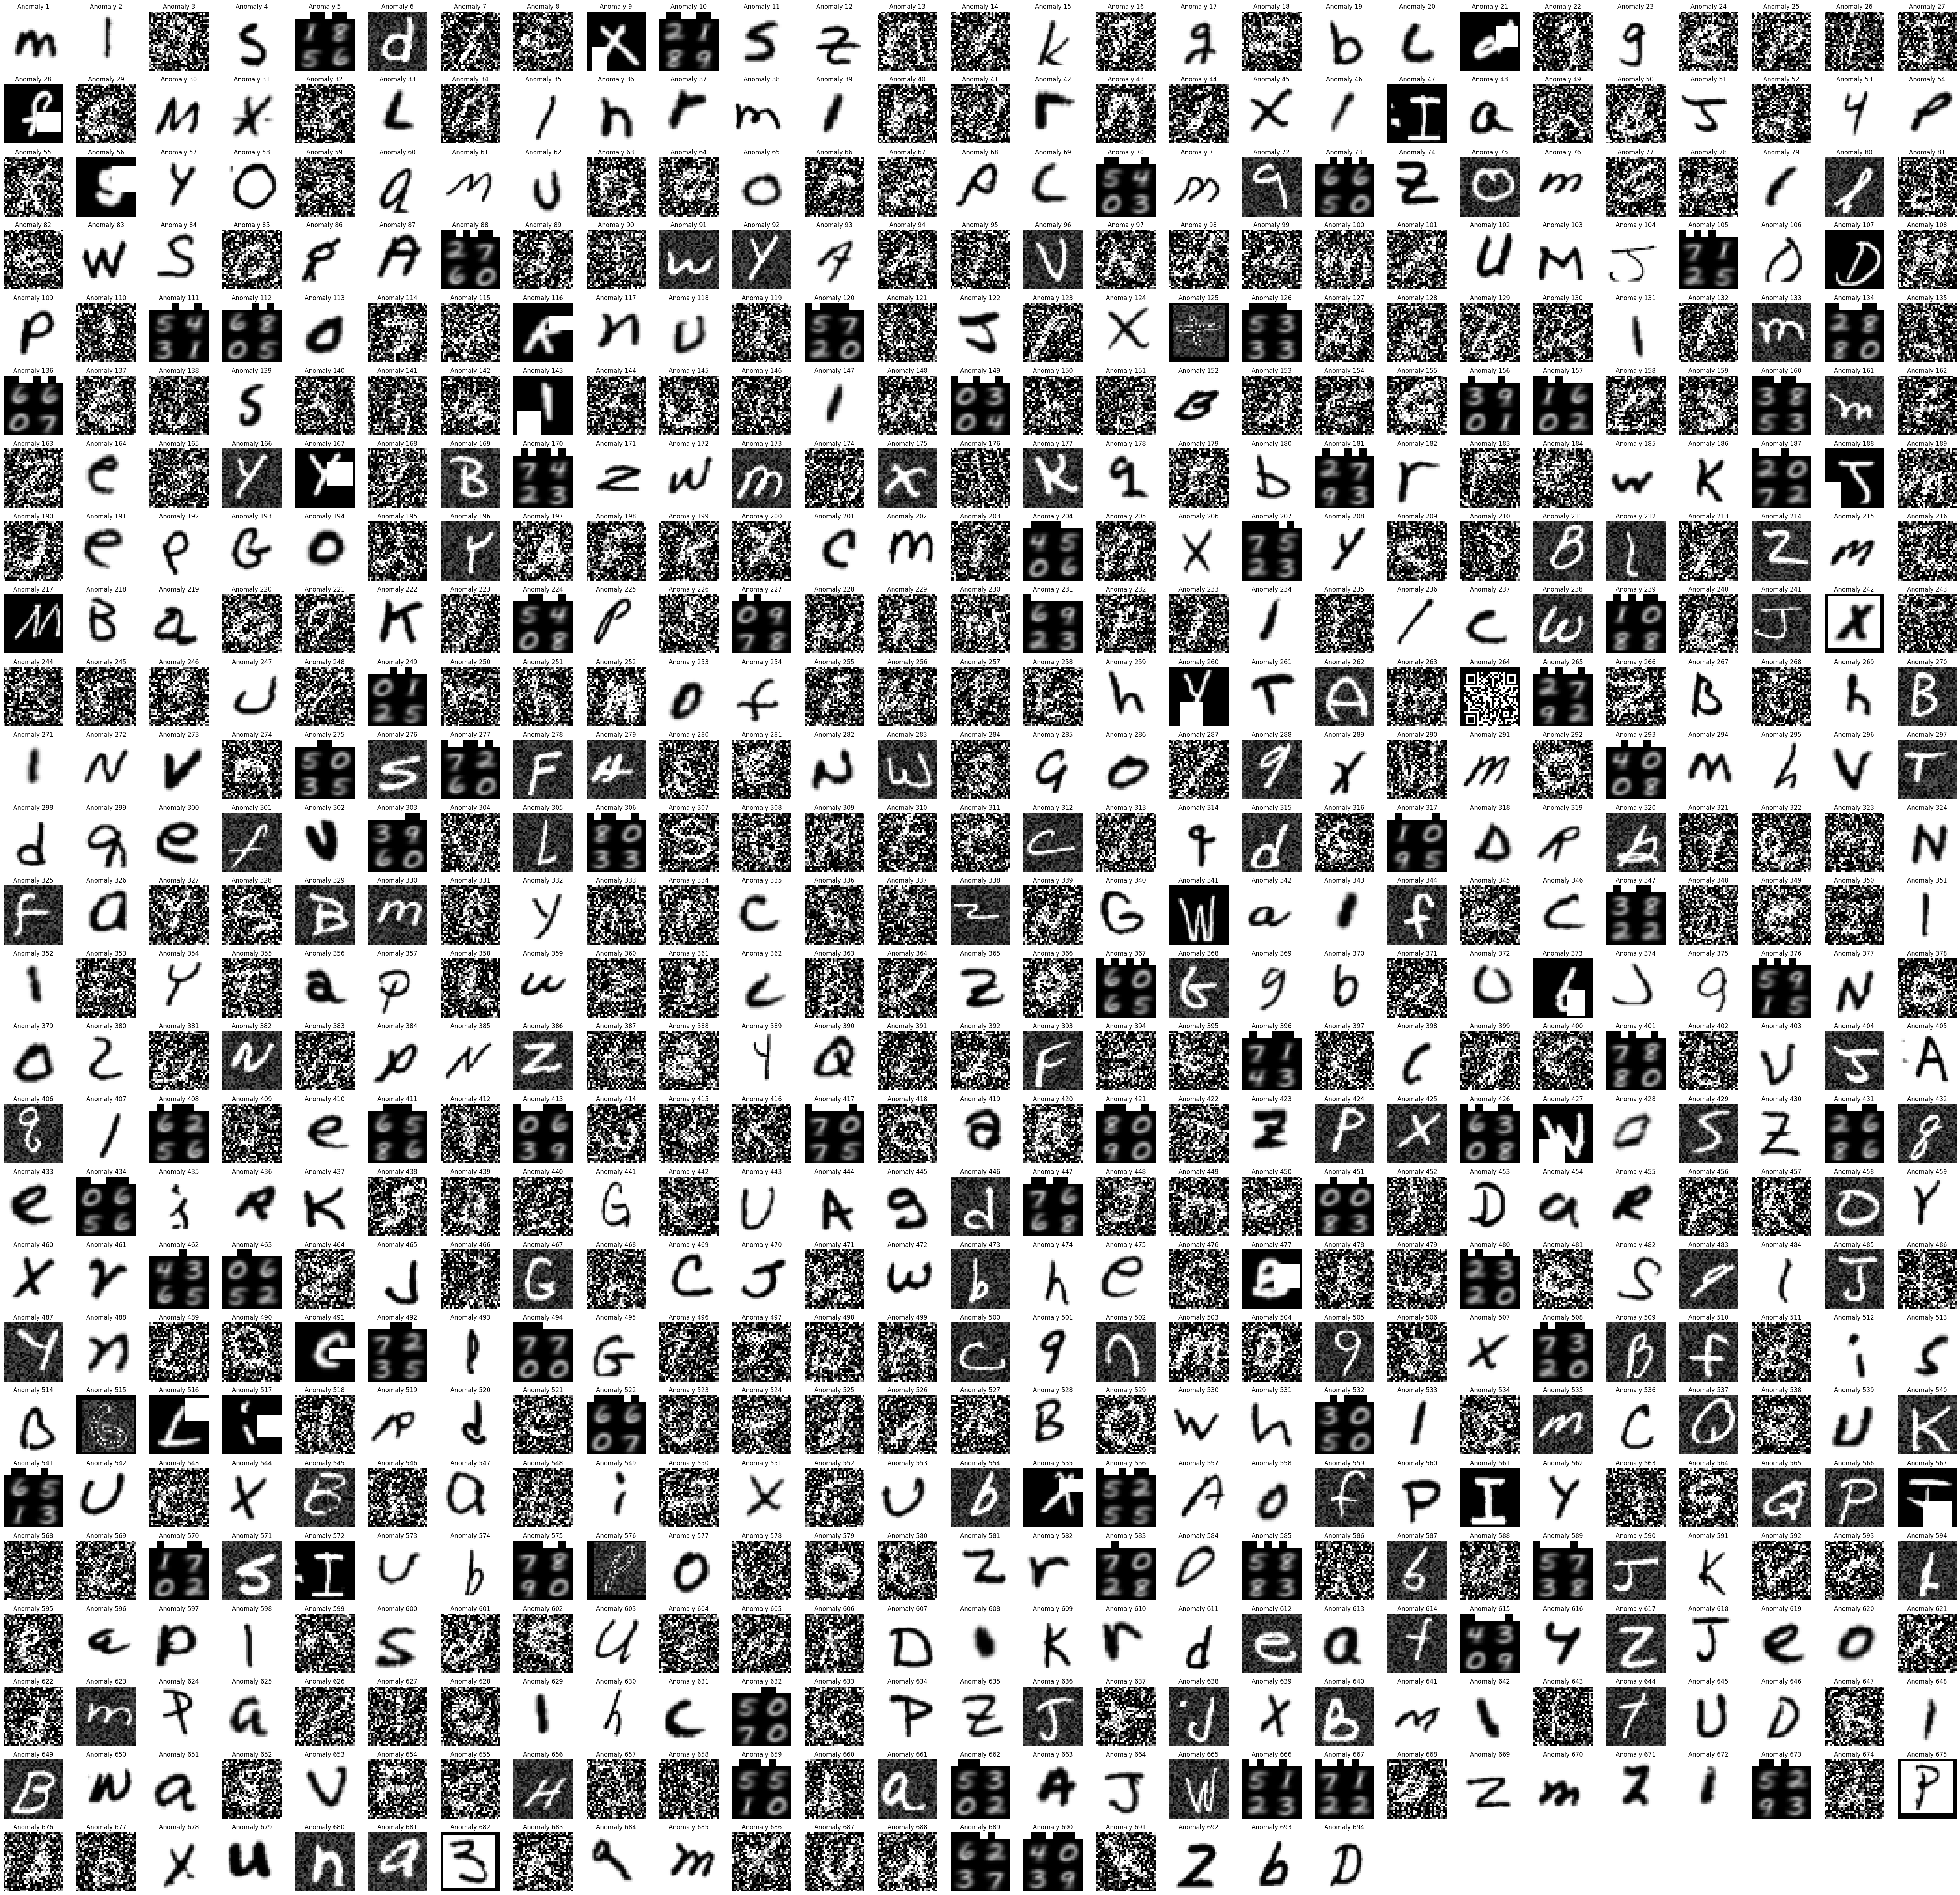

In [16]:
# Code generated with GPT

# visualize all anomalies in a grid

import math


def plot_all_anomalies(original_data, reconstructed_data, anomalies):
    # Get all anomaly indices
    anomaly_indices = np.where(anomalies)[0]
    total_anomalies = len(anomaly_indices)

    # Determine grid size
    grid_size = math.ceil(math.sqrt(total_anomalies))

    # Create the plot
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    for i, idx in enumerate(anomaly_indices):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(original_data[idx, 0].cpu(), cmap="gray")
        plt.title(f"Anomaly {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


plot_all_anomalies(corrupted_images_tensor, reconstructed, anomalies)


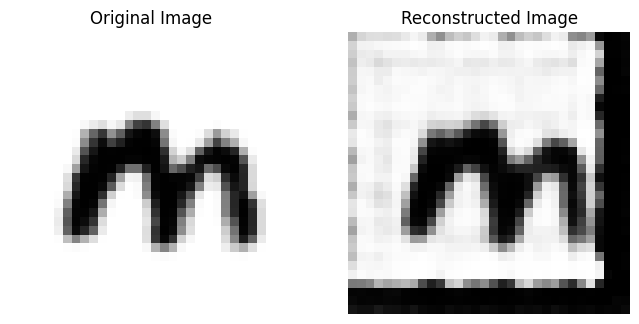

Reconstruction Error: 0.20269347727298737
----


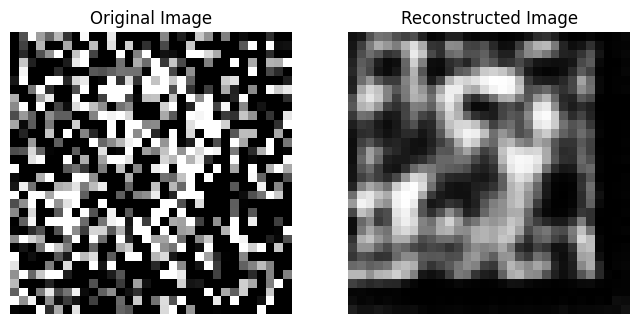

Reconstruction Error: 0.14827361702919006
----


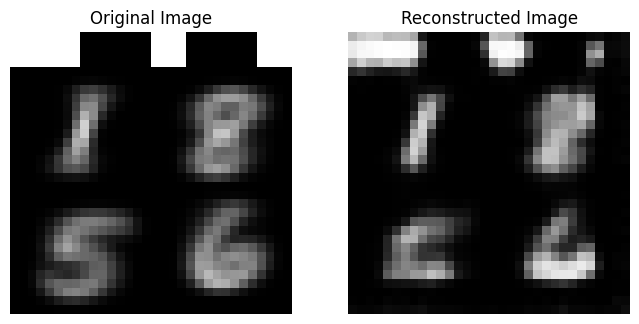

Reconstruction Error: 0.02566627785563469
----


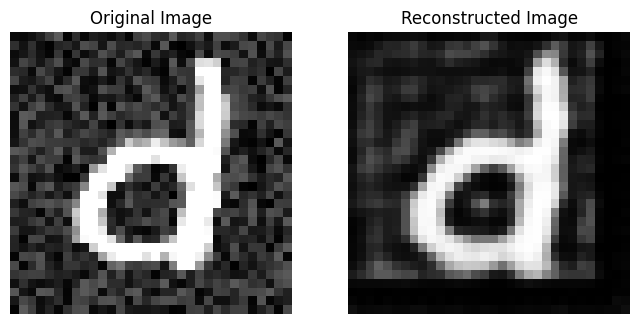

Reconstruction Error: 0.025429347530007362
----


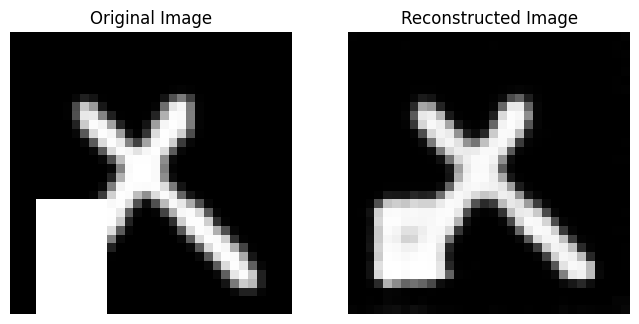

Reconstruction Error: 0.029547765851020813
----


In [17]:
# Code generated with GPT for visualization

# Visualize specific anomalies
def plot_specific_anomalies(original_data, reconstructed_data, anomalies, positions):
    # Get all anomaly indices
    anomaly_indices = np.where(anomalies)[0]
    # Select specific anomalies based on their positions in the anomalies list
    selected_indices = anomaly_indices[positions]

    for idx in selected_indices:
        plt.figure(figsize=(8, 4))
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_data[idx, 0].cpu(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")
        # Reconstructed image
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_data[idx, 0].cpu(), cmap="gray")
        plt.title("Reconstructed Image")
        plt.axis("off")
        plt.show()
        # Show the reconstruction error
        print(f"Reconstruction Error: {errors[idx]}")
        print("----")


# Positions of anomalies to visualize (within the anomalies list)
positions_in_anomalies = [0, 2, 4, 5, 8]

# Get reconstructed images for anomalies
model.eval()
with torch.no_grad():
    corrupted_images_tensor = corrupted_images_tensor.to(device)
    reconstructed = model(corrupted_images_tensor)

# Plot the specific anomalies
plot_specific_anomalies(
    corrupted_images_tensor, reconstructed, anomalies, positions=positions_in_anomalies
)


Types of anomalies:
1. Inverted image- Black and white pixel values are inverted
2. Corrupted image- Significant pixel level corruption, leading to the image losing its structure and random patterns
3. Multiple characters- Two or more Characters merged or pictures merged together within the same image
4. Salt-and-Pepper Noise- Dense "salt-and-pepper" noise, where black and white pixels appear randomly distributed throughout the image
5. Image with missing pixles- Certain pixel data is missing leaving white patches or blank areas


## 2. Diffusion Models

#### Approach:
- A diffusion model is trained to predict the noise added to clean images (from MNIST) during a gradual noise diffusion process
- During inference on corrupted EMNIST, the model attempts to predict the noise added to the input image.
- Anomalies are detected using reconstruction errors (difference between noisy input and the model's predicted denoised output).

In [19]:
# Define transformations: convert to tensor and normalize to [-1, 1] range
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the MNIST dataset
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)

# Create a DataLoader for batching
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Check dataset size
print(f"Number of samples in MNIST training dataset: {len(mnist_data)}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.89MB/s]


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 363kB/s]


Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.72MB/s]


Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.85MB/s]

Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw

Number of samples in MNIST training dataset: 60000


In [21]:
# Code corrected with the help of GPT (time embedding)


class TimeEmbedding(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -math.log(10000) / (half_dim - 1)
        )
        emb = torch.cat(
            [torch.sin(t[:, None] * emb), torch.cos(t[:, None] * emb)], dim=1
        )
        return self.linear2(F.relu(self.linear1(emb)))


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.time_embed = TimeEmbedding(embed_size=128)

        # Update encoder to handle increased input channels
        self.encoder = nn.Sequential(
            nn.Conv2d(
                1 + 128, 64, 3, padding=1
            ),  # Input channels: 1 (image) + 128 (time embedding)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # Generate time embeddings and concatenate with input
        t_embed = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
        t_embed = t_embed.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t_embed], dim=1)

        # Encode and decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
# add_noise corrected with the help of GPT

# Diffusion parameters
T = 100  # Number of timesteps
betas = torch.linspace(1e-4, 0.02, T)  # Noise schedule
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)


# Sample noisy images
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)  # Proper broadcasting
    noisy_image = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return noisy_image, noise


# Reverse process
def denoise(model, xt, t):
    return model(xt, t)


In [23]:
# Prepare MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)


In [40]:
# Code made faster by implementing mixed precision with the help of GPT

# Move model and data to GPU
model = UNet().to(device)

# Initialize model, loss, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Training loop with mixed precision cause it was slow on MPS
epochs = 7
for epoch in range(epochs):
    for images, _ in mnist_loader:
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)
        t_normalized = t.float() / T
        xt, noise = add_noise(images, t)

        optimizer.zero_grad()
        with autocast():
            pred_noise = model(xt, t_normalized)
            loss = criterion(pred_noise, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), "diffusion_mnist.pth")


C:\Users\ameya\AppData\Local\Temp\ipykernel_1296\558494741.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ameya\AppData\Local\Temp\ipykernel_1296\558494741.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/7, Loss: 0.2841
Epoch 2/7, Loss: 0.1542
Epoch 3/7, Loss: 0.1602
Epoch 4/7, Loss: 0.1317
Epoch 5/7, Loss: 0.0940
Epoch 6/7, Loss: 0.1268
Epoch 7/7, Loss: 0.1060


In [31]:
# Prepare corrupted EMNIST dataset
# Code corrected with the help of GPT (channel dimension)

# Normalize and convert corrupted EMNIST to tensors
emnist_images = loaded_images / 255.0  # Scale to [0, 1]
emnist_images = (emnist_images - 0.5) / 0.5  # Normalize to [-1, 1]
emnist_images_tensor = torch.tensor(emnist_images, dtype=torch.float32).unsqueeze(
    1
)  # Add channel dimension

# Create DataLoader for corrupted EMNIST
batch_size = 128
emnist_dataset = torch.utils.data.TensorDataset(emnist_images_tensor)
emnist_loader = torch.utils.data.DataLoader(
    emnist_dataset, batch_size=batch_size, shuffle=False
)


In [41]:
model.eval()

# Anomaly detection on corrupted EMNIST
reconstruction_errors = []
pred_noises = []
original_images = []

with torch.no_grad():
    for (images,) in emnist_loader:
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)  # Random time steps
        t_normalized = t.float() / T  # Normalize time steps

        # Add noise to images
        xt, noise = add_noise(images, t)

        # Predict noise using the trained model
        pred_noise = model(xt, t_normalized)

        # Compute reconstruction error
        errors = torch.mean((xt - pred_noise) ** 2, dim=[1, 2, 3])  # MSE per image
        reconstruction_errors.append(errors.cpu())
        pred_noises.append(pred_noise.cpu())
        original_images.append(images.cpu())

# Combine all batches
reconstruction_errors = torch.cat(reconstruction_errors)
pred_noises = torch.cat(pred_noises)
original_images = torch.cat(original_images)


In [44]:
# Calculate mean and std of reconstruction errors
mean_error = reconstruction_errors.mean().item()
std_error = reconstruction_errors.std().item()
threshold = mean_error + 3 * std_error
anomalies = reconstruction_errors > threshold

# Print anomaly statistics
print(f"Mean Reconstruction Error: {mean_error:.4f}")
print(f"Standard Deviation of Reconstruction Error: {std_error:.4f}")
print(f"Threshold for Anomalies: {threshold:.4f}")
print(f"Number of Anomalies: {torch.sum(anomalies).item()}")


Mean Reconstruction Error: 0.9150
Standard Deviation of Reconstruction Error: 0.3822
Threshold for Anomalies: 2.0617
Number of Anomalies: 58


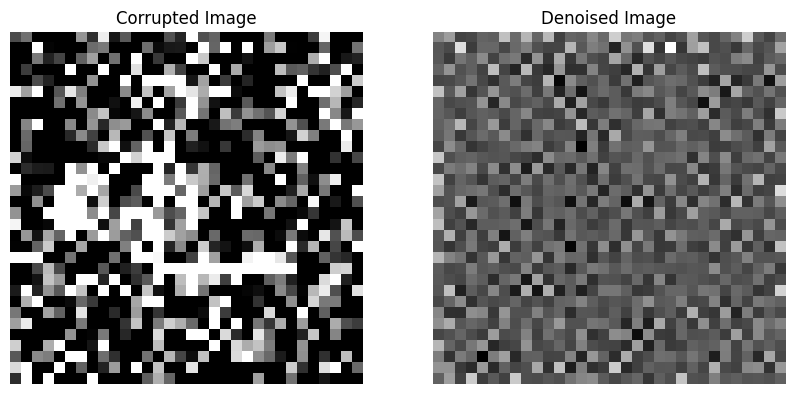

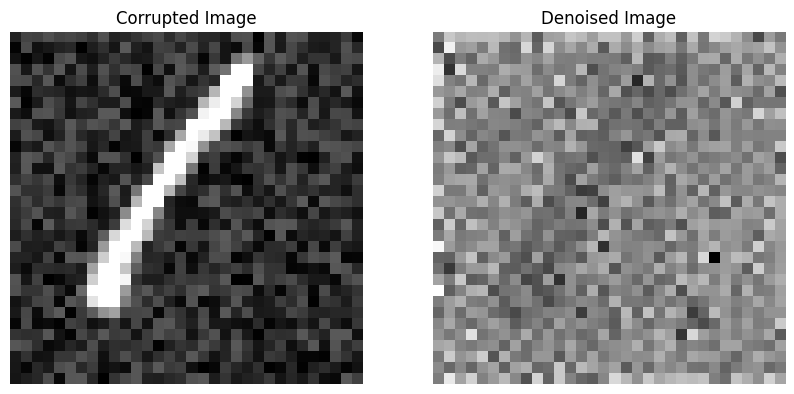

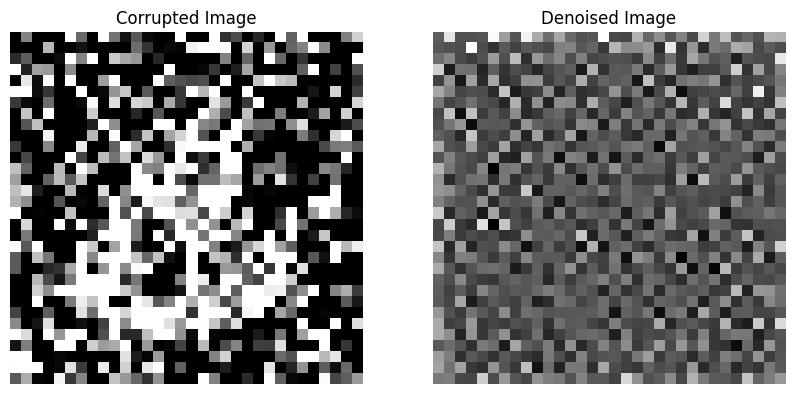

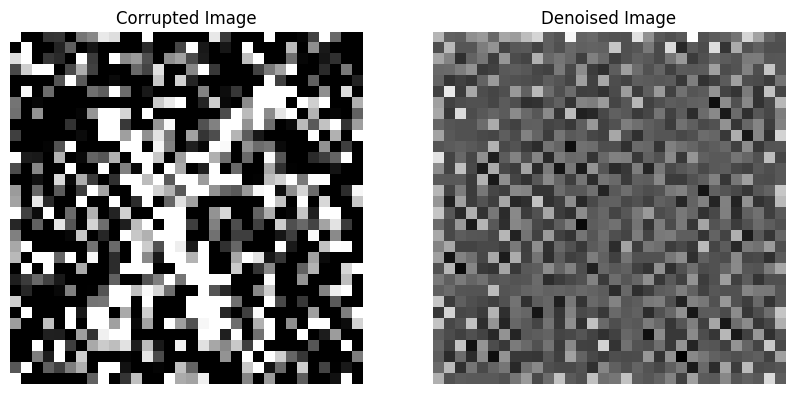

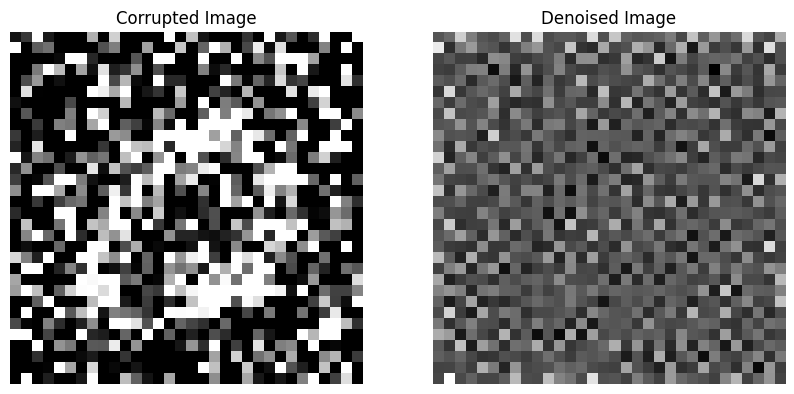

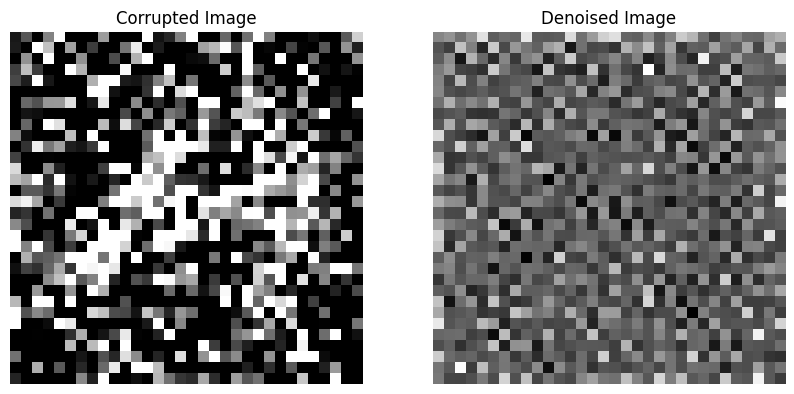

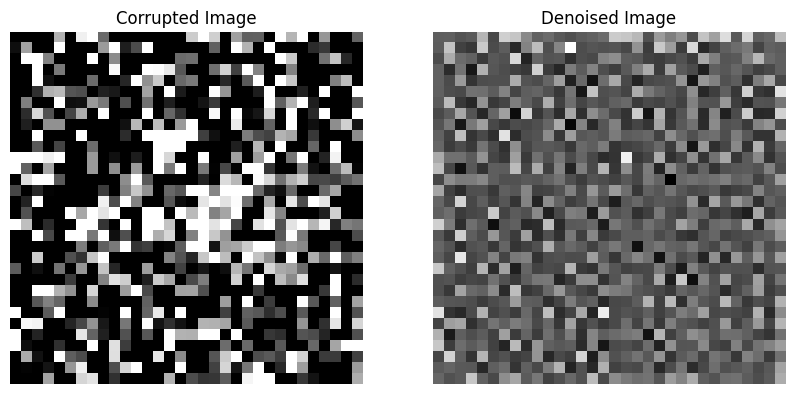

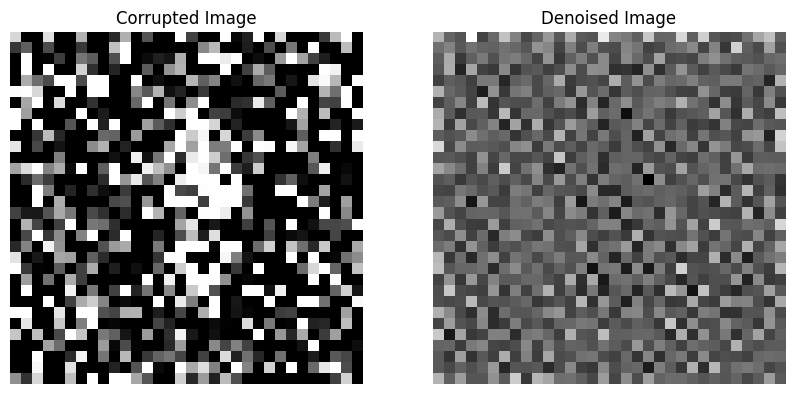

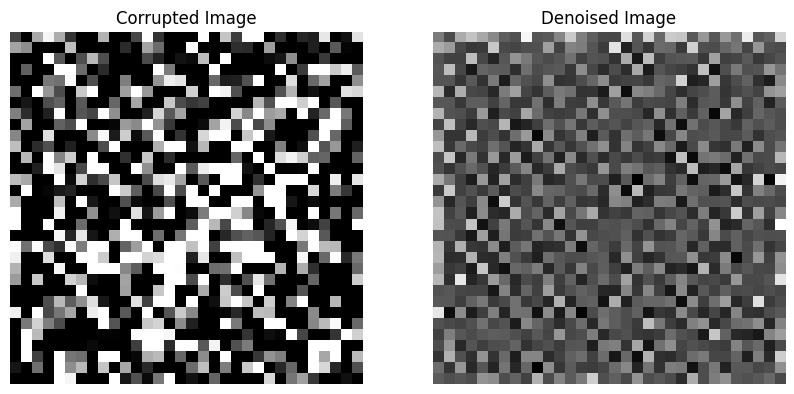

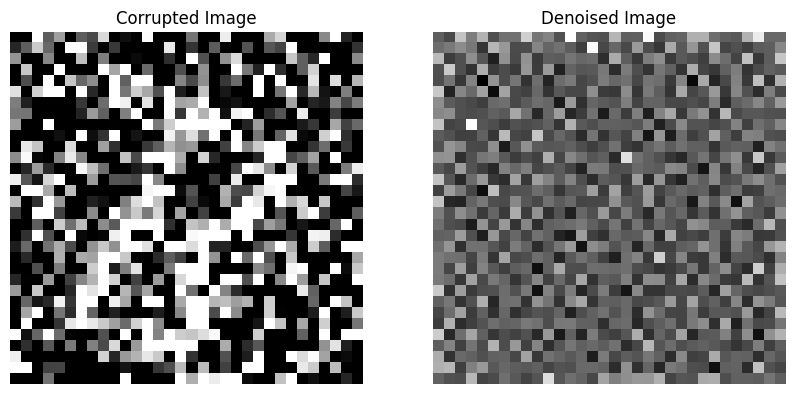

In [45]:
# Code fixed with the help of GPT

# Visualize anomalies
visualized = 0  # Counter for visualized anomalies
max_visualizations = 10  # Maximum anomalies to visualize

for i in range(len(anomalies)):  # Iterate through all images
    if anomalies[i]:  # Check if the image is an anomaly
        corrupted_image = original_images[i].squeeze().numpy()
        denoised_image = pred_noises[i].squeeze().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(corrupted_image, cmap="gray")
        plt.title("Corrupted Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(denoised_image, cmap="gray")
        plt.title("Denoised Image")
        plt.axis("off")

        plt.show()

        visualized += 1
        if visualized >= max_visualizations:
            break  # Stop after visualizing max_visualizations anomalies

if visualized == 0:
    print("No anomalies found for visualization.")


The diffusion model relies on predicting the noise added to an image at different time steps during the forward diffusion process. The random black-and-white pixels in salt-and-pepper noise align well with the random noise the diffusion process generates and learns to model.

### Comparison between the two approaches.

#### CAE:
Strengths:
- Simple to implement and train.
- Effective at detecting structural anomalies
Limitations:
- May not capture very subtle anomalies
- Limited by the capacity of the autoencoder to generalize beyond clean images

#### Diffusion Models:
Strengths:
- Diffusion models can model complex distributions and are effective at reconstructing images with added noise.
Weaknesses:
- Computationally intensive to train and infer.
- Requires careful tuning of diffusion parameters and noise schedules


### Methods to Rebuild a Corrupted Dataset

#### 1. **Inverted Images**
   - **Solution:**
     - Apply color inversion using image processing libraries such as OpenCV or PIL in Python.
     - Color inversion flips pixel values to their opposite (e.g., black to white) to restore the original appearance.
     - Verify the image matches the expected dataset style after applying inversion.
   - **Implementation Example:**

      ```python
      from PIL import ImageOps
      inverted_image = ImageOps.invert(image)
      inverted_image.show()
      ```

- Soruce: https://stackoverflow.com/questions/2498875/how-to-invert-colors-of-image-with-pil-python-imaging  

#### 2. **Rubbish or Noisy Data**
   - **Solution:**
     - Identify the type and intensity of noise (Gaussian, salt-and-pepper, etc.).
     - Use noise reduction techniques:
       - **Gaussian Filtering**: Smoothens the image to reduce noise.
       - **Median Filtering**: Particularly effective against salt-and-pepper noise.
     - For heavy noise, use **denoising autoencoders** to reconstruct the clean image by learning the noise pattern.
   - **Implementation Example:**

     ```python
     import cv2
     denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
     cv2.imshow('Denoised', denoised_image)
     
     ```
- Sources: https://stackoverflow.com/questions/62042172/how-to-remove-noise-in-image-opencv-python
https://stackoverflow.com/questions/66395494/how-to-reduce-the-noise-of-an-image-on-python
https://www.omdena.com/blog/denoising-autoencoders
#### 3. **Blurred Images**
   - **Solution:**
     - **Deblurring Techniques**:
       - **Wiener Filtering**: Estimate the original signal by minimizing the mean square error.
       Pros: Computationally efficient and easy to implement
       Cons:Requires precise knowledge of the blur kernel and noise characteristics, these are not always known like for this case.  
       - **Blind Deconvolution**: Estimate both the blur kernel and the deblurred image.
       Pros: Suitable when the blur kernel is unknown, making it flexible for real-world scenarios
       Cons:Computationally expensive and slow, particularly for high-resolution images  
       - **Deep Learning Models**: Use pre-trained models like DeblurGAN for complex cases.
     - Ensure the result preserves critical features of the original image without introducing
     artifacts.
     Pros: Can generalize well to various types of blur when trained on a large and diverse dataset
     Cons: Performance depends on the quality and diversity of the training data and expensive. 
   - **Implementation Example:**
     ```python
     import cv2
     kernel = cv2.getGaussianKernel(ksize=5, sigma=1)
     deblurred_image = cv2.filter2D(image, -1, kernel)
     cv2.imshow('Deblurred', deblurred_image)
     ```
- Sources: Call with AI expert from my company that explianed to me what all of this meant. His name is Mahmoud Bidry, PhD Student in AI.

#### 4. **Pixel Loss**
   - **Solution:**
     - **Interpolation Techniques**:
       - **Bilinear or Bicubic Interpolation**: Estimate missing pixels using neighboring ones.
       Pros: Quick and computationally efficient for small regions of missing pixels
       Cons: Limited effectiveness for large-scale pixel loss. 
     - **Inpainting Methods**:
       - Use neural networks designed for inpainting, such as DeepFill, to predict and fill missing regions.
       - Use OpenCV's `inpaint` function for small missing regions.
     - Validate the reconstructed image against the expected dataset pattern to avoid artifacts.
     Pros: Capable of restoring larger missing regions.
     Cons: May require training on a dataset similar to the corrupted one for optimal results, also very expensive. 
   - **Implementation Example:**
     ```python
     import cv2
     inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
     cv2.imshow('Inpainted', inpainted_image)
     ```
- Source: https://www.youtube.com/watch?v=FAwA6LzFVFw&ab_channel=DSPNITAP
https://www.geeksforgeeks.org/python-opencv-bicubic-interpolation-for-resizing-image/
This amazing code on github: https://github.com/aGIToz/PyInpaint

Disclaimer: we used GPT to help with the synthesis of this markdown.